# Titanic Machine Learning Problem

Using the Titanic dataset from kaggle (https://www.kaggle.com/c/titanic) to solve the problem

## Problem set-up:


The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

For this problem, we want to complete the analysis of what sorts of people were likely to survive. In particular, we apply the tools of machine learning to predict which passengers survived the tragedy. (https://www.kaggle.com/c/titanic)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import pydotplus 
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [30]:
train = pd.read_csv('train.csv')
train = train.dropna()
print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C103        S  


### Some feature engineering

Let's exclude the text features for the moment, because we will learn how to handle text features later. Text features here are Name and Ticket.

Features Sex, Embarked, and Cabin need to translated to numbers and maybe become categorical features. 

In [31]:
def word2letter(X_word):
    X_letter = []

    for x in X_word:
        X_letter.append(x[0])
    return X_letter
    
train['Cabin_letter'] = word2letter(train['Cabin'])

In [32]:
def text2number(X_word, words):
    numbers = range(len(words))
    
    X_number = X_word.copy()
    for n, w in zip(numbers, words):
        X_number[X_word == w] = n
    return X_number

embarked_words = list(set(train['Embarked']))
train['Embarked_number'] = text2number(train['Embarked'], embarked_words)

sex_words = list(set(train['Sex']))
train['Sex_number'] = text2number(train['Sex'], sex_words)

cabin_words = list(set(train['Cabin_letter']))
train['Cabin_number'] = text2number(train['Cabin_letter'], cabin_words)

print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked Cabin_letter Embarked_number  \
1       0  PC 17599  71.2833   C85        C            C               1   
3       0    113803  53.1000  C123        S            C               2   
6       0     17463  51.8625   E46        S            E               2   
10  

### Plot the features

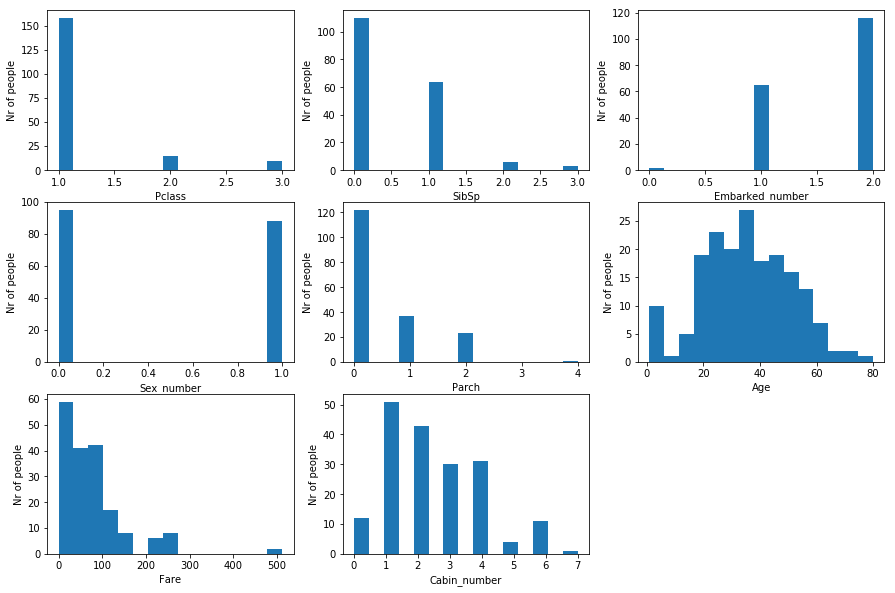

In [33]:
fig = plt.figure(figsize=(15, 10))

for idx, f in enumerate(['Pclass', 'SibSp','Embarked_number','Sex_number', 'Parch','Age','Fare','Cabin_number']):
    ax = fig.add_subplot(3,3,idx+1)
    ax.hist(train[f], 15)
    ax.set_xlabel(f)
    ax.set_ylabel('Nr of people')
    
plt.show()

Features are problematic, whose entries are numbers, but the value of the number has no meaning. These features pretend to have an order, where there is no. Features like this, we rebuild to categorical features. For each unique possible value, we build a new column which has entries 0 and 1.

In [34]:
## Make categorical features for Embarked
X_num = train['Embarked_number']
nmax = max(X_num)+1

for num in range(nmax):
    X_cat = np.zeros_like(X_num)
    for idx, entry in enumerate(X_num):
        if entry == num:
            X_cat[idx] = 1
    name = 'Embarked_' + str(num)
    train[name] = X_cat

## Make categorical features for Cabin
X_num = train['Cabin_number']
nmax = max(X_num)+1

for num in range(nmax):
    X_cat = np.zeros_like(X_num)
    for idx, entry in enumerate(X_num):
        if entry == num:
            X_cat[idx] = 1
    name = 'Cabin_' + str(num)
    train[name] = X_cat

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_1,Embarked_2,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,1,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,1,0,0,0,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,0,1,0,0,0,1,0,0,0,0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,...,0,1,0,0,0,0,0,1,0,0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,...,0,1,0,1,0,0,0,0,0,0


### Extract the features we want to use in the model

Now we extract all the features we want to use for training and get the train_labels.

In [35]:
## Features are translated to numbers
X = train[['Pclass', 'SibSp', 'Parch', 'Embarked_0', 'Embarked_1', 'Embarked_2','Sex_number', 'Age', 'Fare', 
           'Cabin_0', 'Cabin_1', 'Cabin_2', 'Cabin_3', 'Cabin_4', 'Cabin_5', 'Cabin_6', 'Cabin_7']].values
Y = train['Survived'].values        

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

M = X.shape[0]
M_train = int(M*0.8)

X_train = X[:M_train, :]
X_dev = X[M_train:, :]
Y_train = Y[:M_train]
Y_dev = Y[M_train:]

### Build a decision tree
Let's try to build a decision tree model.

In [36]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=10)
dt.fit(X_train, Y_train)
print('Accuracy (a decision tree):', dt.score(X_dev, Y_dev))


dot_data = export_graphviz(dt, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("tree.pdf") 

('Accuracy (a decision tree):', 0.72972972972972971)


True

## Ensemble methods

### Random forest

In [37]:
vec_acc = []
for num_est in [5,10,50,100, 500, 800, 1000, 1500]:
    rfc = RandomForestClassifier(criterion = "entropy", n_estimators=num_est)
    rfc.fit(X_train, Y_train)
    acc = rfc.score(X_dev, Y_dev)
    vec_acc.append(acc)
    print('Accuracy (a random forest):', rfc.score(X_dev, Y_dev))
plt.plot(vec_acc)

('Accuracy (a random forest):', 0.70270270270270274)
('Accuracy (a random forest):', 0.7567567567567568)
('Accuracy (a random forest):', 0.67567567567567566)
('Accuracy (a random forest):', 0.7567567567567568)
('Accuracy (a random forest):', 0.7567567567567568)
('Accuracy (a random forest):', 0.7567567567567568)
('Accuracy (a random forest):', 0.7567567567567568)
('Accuracy (a random forest):', 0.7567567567567568)


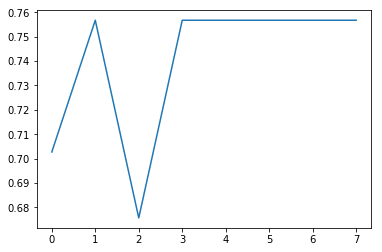

In [38]:
plt.show()

### More ensemble methods

Build a K-Nearest-Neighbor model

In [43]:
k_vec = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
acc_vec = []
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    #print('Accuracy for %i is %f' %(k, acc))
    
best_k = k_vec[np.argmax(acc_vec)]
print('Best k is: ', best_k, ' with accuracy ', max(acc_vec))

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, Y_train)
knn_preds = knn.predict(X_dev)

('Best k is: ', 7, ' with accuracy ', 0.78378378378378377)


Build a Logistic Regression model with L2-Regularization

In [44]:
c_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
acc_vec = []
for c in c_vec:
    lr1 = LogisticRegression(penalty='l1', C=c)
    lr1.fit(X_train, Y_train)
    preds = lr1.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    #print('Accuracy for %i is %f' %(c, acc))
    
best_c = c_vec[np.argmax(acc_vec)]
print('Best c is: ', best_c, ' with accuracy ', max(acc_vec))

lr1 = LogisticRegression(penalty='l1', C=best_c)
lr1.fit(X_train, Y_train)
lr1_preds = lr1.predict(X_dev)

('Best c is: ', 0.001, ' with accuracy ', 0.7567567567567568)


Build a Decision Tree model 

In [45]:
d_vec = [1,3,5,7,9,11,13,15,17,19]
acc_vec = []
for d in d_vec:
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=d)
    dt.fit(X_train, Y_train)
    preds = dt.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    #print('Accuracy for %i is %f' %(d, acc))
    
best_d = d_vec[np.argmax(acc_vec)]
print('Best depth is: ', best_d, ' with accuracy ', max(acc_vec))

dt = DecisionTreeClassifier(criterion="entropy", max_depth=best_d)
dt.fit(X_train, Y_train)
dt_preds = lr1.predict(X_dev)

('Best depth is: ', 3, ' with accuracy ', 0.72972972972972971)


We take a vote using all predictions from the models

In [46]:
final_preds = []
for k, l2, l1, d in zip(knn_preds, lr2_preds, lr1_preds, dt_preds):
    final_preds.append(np.round((k+l2+l2+d) / 4))
acc = np.mean(final_preds == Y_dev)
print('The final accuracy is: ', acc)

NameError: name 'lr2_preds' is not defined

### K-Nearest Nerighbors

In [47]:
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap

In [48]:
# Load the data, which is included in sklearn.
iris = load_iris()
target_names = iris.target_names
feature_names = iris.feature_names
print('Iris target names:', target_names[:2])
print('Iris feature names:', feature_names)
X, Y = iris.data, iris.target

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
X_train, Y_train = X[:50], Y[:50]
X_dev, Y_dev = X[50:100], Y[50:100]
X_test, Y_test = X[100:], Y[100:]

('Iris target names:', array(['setosa', 'versicolor'],
      dtype='|S10'))
('Iris feature names:', ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])


### Apply K-Nearest-Neighbors
We apply K-Nearest-Neighbors and use the dev data to find the best value for k.

In [49]:
k_vec = [1,2,3,4,5,6,7,8,9,10]
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    print('Accuracy for %i is %f' %(k, acc))

Accuracy for 1 is 0.940000
Accuracy for 2 is 0.900000
Accuracy for 3 is 0.980000
Accuracy for 4 is 0.940000
Accuracy for 5 is 0.940000
Accuracy for 6 is 0.920000
Accuracy for 7 is 0.940000
Accuracy for 8 is 0.940000
Accuracy for 9 is 0.940000
Accuracy for 10 is 0.920000


We find the best accuracy 0.98 for k=3.

We try different metrics. Here is a link to some pre-implemented distance metrics. The default metric is the Euclidean metric.

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

In [50]:
k_vec = [1,2,3,4,5,6,7,8,9,10]
acc_vec = []
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=3)
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    print('Accuracy for %i is %f' %(k, acc))
print('\nBest accuracy is %f with k=%i.\n\n' %(max(acc_vec), np.argmax(acc_vec)+1))
    
acc_vec = []
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    print('Accuracy for %i is %f' %(k, acc))
print('\nBest accuracy is %f with k=%i.\n\n' %(max(acc_vec), np.argmax(acc_vec)+1))
    
acc_vec = []
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)
    print('Accuracy for %i is %f' %(k, acc))
print('\nBest accuracy is %f with k=%i.' %(max(acc_vec), np.argmax(acc_vec)+1))

Accuracy for 1 is 0.940000
Accuracy for 2 is 0.900000
Accuracy for 3 is 0.980000
Accuracy for 4 is 0.940000
Accuracy for 5 is 0.940000
Accuracy for 6 is 0.920000
Accuracy for 7 is 0.960000
Accuracy for 8 is 0.940000
Accuracy for 9 is 0.940000
Accuracy for 10 is 0.920000

Best accuracy is 0.980000 with k=3.


Accuracy for 1 is 0.920000
Accuracy for 2 is 0.900000
Accuracy for 3 is 0.960000
Accuracy for 4 is 0.940000
Accuracy for 5 is 0.960000
Accuracy for 6 is 0.940000
Accuracy for 7 is 0.960000
Accuracy for 8 is 0.940000
Accuracy for 9 is 0.960000
Accuracy for 10 is 0.940000

Best accuracy is 0.960000 with k=3.


Accuracy for 1 is 0.960000
Accuracy for 2 is 0.940000
Accuracy for 3 is 0.980000
Accuracy for 4 is 0.900000
Accuracy for 5 is 0.900000
Accuracy for 6 is 0.900000
Accuracy for 7 is 0.900000
Accuracy for 8 is 0.900000
Accuracy for 9 is 0.920000
Accuracy for 10 is 0.920000

Best accuracy is 0.980000 with k=3.


### Check final error on test set 

We take the best KNN with the default metric and k=3 and calculate the test error.

In [52]:
nn = KNeighborsClassifier(n_neighbors=3)
knn.fit(np.concatenate((X_train, X_dev), axis=0), np.concatenate((Y_train, Y_dev), axis = 0))
preds = knn.predict(X_test)
acc = np.mean(preds == Y_test)
print('Accuracy for %i is %f' %(3, acc))

Accuracy for 3 is 0.980000


### Plotting the data

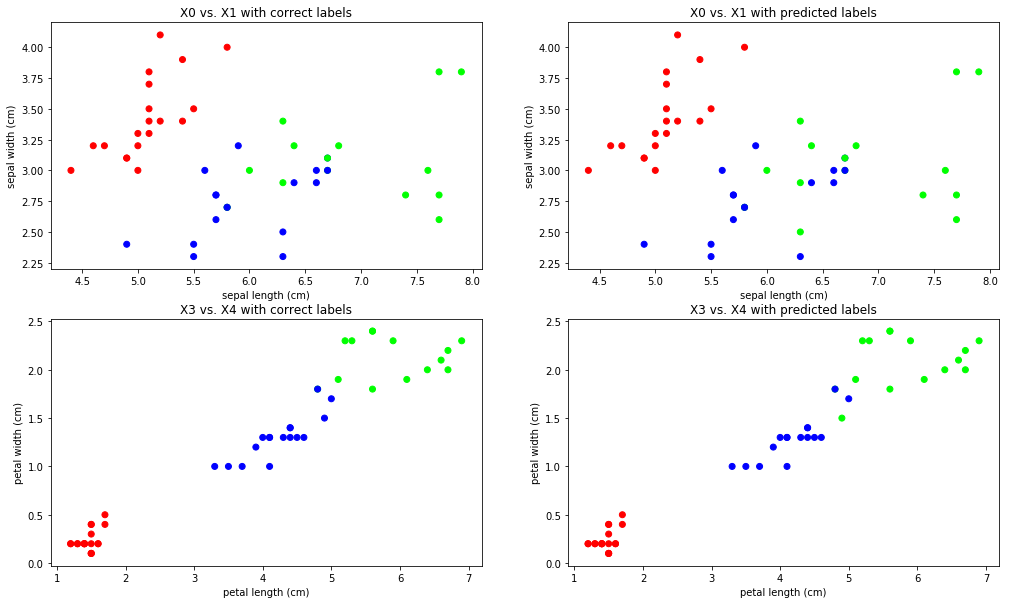

In [53]:
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])

fig = plt.figure(figsize=(17,10))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(X_test[:,0], X_test[:,1], c = Y_test, cmap=cm_bright)
ax1.set_title("X0 vs. X1 with correct labels")
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(X_test[:,0], X_test[:,1], c = preds, cmap=cm_bright)
ax2.set_title("X0 vs. X1 with predicted labels")
ax2.set_xlabel(feature_names[0])
ax2.set_ylabel(feature_names[1])

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(X_test[:,2], X_test[:,3], c = Y_test, cmap=cm_bright)
ax3.set_title("X3 vs. X4 with correct labels")
ax3.set_xlabel(feature_names[2])
ax3.set_ylabel(feature_names[3])

ax4 = fig.add_subplot(2,2,4)
ax4.scatter(X_test[:,2], X_test[:,3], c = preds, cmap=cm_bright)
ax4.set_title("X3 vs. X4 with predicted labels")
ax4.set_xlabel(feature_names[2])
ax4.set_ylabel(feature_names[3])

plt.show()